In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

# Config

In [2]:
class Config:
    BATCH_SIZE=1024
    N_epoch=30
    device="cpu"

In [3]:
%%time
train_df = pd.read_csv("data/train.csv",
                       usecols=['session_id', 'elapsed_time','text_fqid', 'level_group', 'page'],
                       dtype={
                           'elapsed_time': np.float32,
                           'page': np.float16
                       })
train_df.head()

CPU times: user 7.37 s, sys: 392 ms, total: 7.76 s
Wall time: 7.77 s


,session_id,elapsed_time,page,text_fqid,level_group
0,20090312431273200,0.0,NaN,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1323.0,NaN,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,831.0,NaN,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
3,20090312431273200,1147.0,NaN,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
4,20090312431273200,1863.0,NaN,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13174211 entries, 0 to 13174210
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   session_id    int64  
 1   elapsed_time  float32
 2   page          float16
 3   text_fqid     object 
 4   level_group   object 
dtypes: float16(1), float32(1), int64(1), object(2)
memory usage: 376.9+ MB


In [5]:
train_df.page.fillna(-1, inplace=True)
train_df.page = train_df.page.astype(np.int8)

train_df.head()

,session_id,elapsed_time,page,text_fqid,level_group
0,20090312431273200,0.0,-1,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1323.0,-1,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,831.0,-1,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
3,20090312431273200,1147.0,-1,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
4,20090312431273200,1863.0,-1,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [6]:
train_df.level_group.unique()

array(['0-4', '5-12', '13-22'], dtype=object)

In [7]:
level0_df = train_df[train_df.level_group == '0-4']
level1_df = train_df[train_df.level_group == '5-12']
level2_df = train_df[train_df.level_group == '13-22']

level0_df = level0_df[(~level0_df.text_fqid.isna()) | (level0_df.page!=-1)]
level1_df = level1_df[(~level1_df.text_fqid.isna()) | (level1_df.page!=-1)]
level2_df = level2_df[(~level2_df.text_fqid.isna()) | (level2_df.page!=-1)]

level0_df.drop(columns=['level_group'], inplace=True)
level1_df.drop(columns=['level_group'], inplace=True)
level2_df.drop(columns=['level_group'], inplace=True)

level0_df['log_elapsed_time'] = np.log(1+(level0_df.elapsed_time/1000/60))
level1_df['log_elapsed_time'] = np.log(1+(level1_df.elapsed_time/1000/60))
level2_df['log_elapsed_time'] = np.log(1+(level2_df.elapsed_time/1000/60))

print(level0_df.shape, level1_df.shape, level2_df.shape)

level1_df.head()

(789173, 5) (1728413, 5) (2574105, 5)


,session_id,elapsed_time,page,text_fqid,log_elapsed_time
166,20090312431273200,222334.0,-1,tunic.capitol_0.hall.boss.talktogramps,1.548746
167,20090312431273200,223251.0,-1,tunic.capitol_0.hall.boss.talktogramps,1.551989
178,20090312431273200,234969.0,-1,tunic.historicalsociety.closet_dirty.what_happ...,1.592526
179,20090312431273200,235717.0,-1,tunic.historicalsociety.closet_dirty.what_happ...,1.595058
180,20090312431273200,236350.0,-1,tunic.historicalsociety.closet_dirty.what_happ...,1.597197


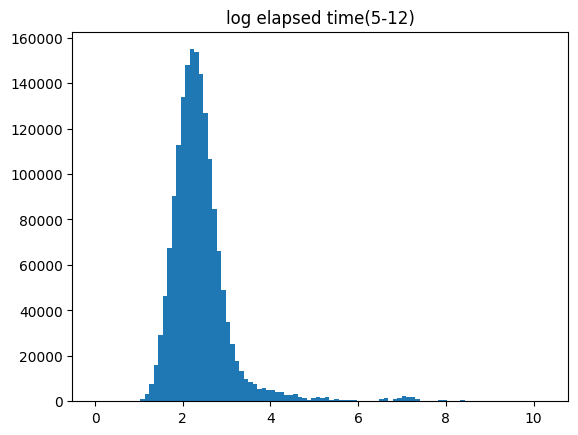

In [8]:
plt.title("log elapsed time(5-12)")
plt.hist(level1_df.log_elapsed_time, bins=100)
plt.show()

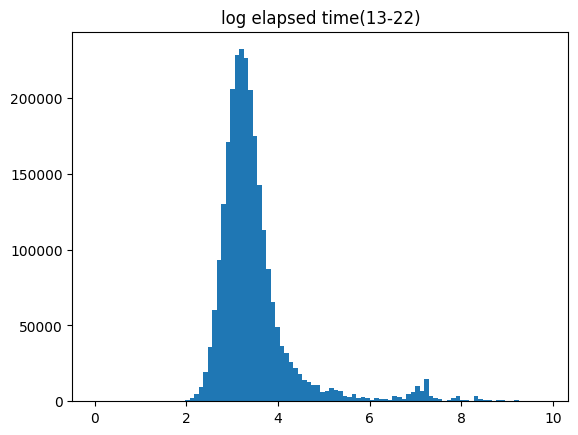

In [9]:
plt.title("log elapsed time(13-22)")
plt.hist(level2_df.log_elapsed_time, bins=100)
plt.show()

In [10]:
print(level0_df.log_elapsed_time.mean())
print(level1_df.log_elapsed_time.mean())
print(level2_df.log_elapsed_time.mean())

0.92736715
2.4087462
3.4818292


# pre process elapsed time

In [11]:
def get_page_features(df):
    log_elapsed_mean = df.log_elapsed_time.mean()
    page_feat_df = pd.pivot_table(
        df[df.page!=-1],
        index='session_id',
        columns='page',
        values="log_elapsed_time",
        aggfunc=np.max
    )
    
    page_feat_df.fillna(0.0, inplace=True)
    page_feat_df = page_feat_df-log_elapsed_mean
    page_feat_df = page_feat_df.clip(-log_elapsed_mean, 5)
    page_feat_df.columns=["page"+str(c) for  c in page_feat_df.columns]
    page_feat_df = page_feat_df.reset_index()
    
    return page_feat_df

In [12]:
def get_text_features(df):
    log_elapsed_mean = df.log_elapsed_time.mean()
    feat_df = pd.pivot_table(
        df[~df.text_fqid.isna()],
        index='session_id',
        columns='text_fqid',
        values="log_elapsed_time",
        aggfunc=np.mean
    )
    
    feat_df.fillna(0.0, inplace=True)
    feat_df = feat_df-log_elapsed_mean
    feat_df = feat_df.clip(-log_elapsed_mean, 5)
    feat_df = feat_df.reset_index()
    
    return feat_df

In [13]:
def build_features(df):
    text_feat_df = get_text_features(df)
    page_feat_df = get_page_features(df)
    
    feat_df = text_feat_df.merge(page_feat_df, how='left')
    feat_df.fillna(0.0, inplace=True)
    FEATURE_COLUMNS=[colname for colname in feat_df.columns if colname!='session_id']
    return FEATURE_COLUMNS, feat_df

In [14]:
level0_columns, level0_feat_df = build_features(level0_df)
level1_columns, level1_feat_df = build_features(level1_df)
level2_columns, level2_feat_df = build_features(level2_df)

print("number of level0 columns:", len(level0_columns))
print("number of level1 columns:", len(level1_columns))
print("number of level2 columns:", len(level2_columns))

number of level0 columns: 29
number of level1 columns: 54
number of level2 columns: 64


# train labels

In [15]:
train_label = pd.read_csv("data/train_labels.csv")

train_label['qno'] = train_label.session_id.apply(lambda session_id: int(session_id.split("_")[1][1:]))
train_label['session_id']= train_label.session_id.apply(lambda session_id: int(session_id.split("_")[0]))
train_label.head()

,session_id,correct,qno
0,20090312431273200,1,1
1,20090312433251036,0,1
2,20090314121766812,1,1
3,20090314363702160,1,1
4,20090314441803444,1,1


In [16]:
train0_label = train_label[(train_label.qno<4)].copy()
train1_label = train_label[(train_label.qno>=4) & (train_label.qno <=13)].copy()
train2_label = train_label[(train_label.qno>=14)].copy()

train0_label = train0_label.groupby("session_id")[['qno', 'correct']].agg(list).reset_index()
train1_label = train1_label.groupby("session_id")[['qno', 'correct']].agg(list).reset_index()
train2_label = train2_label.groupby("session_id")[['qno', 'correct']].agg(list).reset_index()

train1_label.head()

,session_id,qno,correct
0,20090312431273200,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]"
1,20090312433251036,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[1, 0, 1, 1, 0, 1, 0, 0, 1, 0]"
2,20090314121766812,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[0, 0, 1, 1, 0, 0, 1, 1, 1, 0]"
3,20090314363702160,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]"
4,20090314441803444,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[1, 1, 1, 0, 1, 0, 1, 0, 1, 0]"


In [17]:
train2_label.head()

,session_id,qno,correct
0,20090312431273200,"[14, 15, 16, 17, 18]","[1, 1, 0, 1, 1]"
1,20090312433251036,"[14, 15, 16, 17, 18]","[1, 0, 1, 0, 1]"
2,20090314121766812,"[14, 15, 16, 17, 18]","[1, 1, 1, 0, 1]"
3,20090314363702160,"[14, 15, 16, 17, 18]","[1, 0, 0, 1, 1]"
4,20090314441803444,"[14, 15, 16, 17, 18]","[1, 1, 1, 1, 1]"


In [18]:
level0_feat_df = level0_feat_df.merge(train0_label)
level1_feat_df = level1_feat_df.merge(train1_label)
level2_feat_df = level2_feat_df.merge(train2_label)

level0_feat_df.head(2)

,session_id,tunic.capitol_0.hall.chap1_finale_c,tunic.historicalsociety.basement.janitor,tunic.historicalsociety.closet.doorblock,tunic.historicalsociety.closet.gramps.intro_0_cs_0,tunic.historicalsociety.closet.intro,tunic.historicalsociety.closet.notebook,tunic.historicalsociety.closet.photo,tunic.historicalsociety.closet.retirement_letter.hub,tunic.historicalsociety.closet.teddy.intro_0_cs_0,...,tunic.historicalsociety.entry.groupconvo,tunic.historicalsociety.entry.wells.talktogramps,tunic.historicalsociety.stacks.outtolunch,tunic.kohlcenter.halloffame.block_0,tunic.kohlcenter.halloffame.plaque.face.date,tunic.kohlcenter.halloffame.togrampa,page0,page1,qno,correct
0,20090312431273200,-0.927367,-0.124208,-0.927367,-0.899255,-0.927367,-0.586761,-0.730841,-0.487229,-0.82336,...,-0.278038,-0.155001,0.113057,-0.927367,0.337781,0.350609,0.000000,0.000000,"[1, 2, 3]","[1, 1, 1]"
1,20090312433251036,-0.927367,-0.927367,-0.927367,-0.915892,-0.892576,-0.743477,-0.927367,-0.927367,-0.86331,...,-0.324710,-0.927367,-0.927367,-0.927367,0.463983,0.481438,-0.219652,-0.927367,"[1, 2, 3]","[0, 1, 1]"


# Dataset

In [19]:
class PSPDataset(torch.utils.data.Dataset):
    def __init__(self, X, qno_lst, correct_lst, min_qno):
        self.X = X; 
        self.qno_lst=qno_lst
        self.correct_lst = correct_lst
        self.min_qno=min_qno
        self.max_labels = qno_lst.shape[-1]
        
    def __getitem__(self, idx):
        X = self.X[idx];
        y = np.zeros(self.max_labels)
        y[ self.qno_lst[idx]-self.min_qno ] = self.correct_lst[idx]
        
        X = torch.tensor(X, dtype=torch.float32)
        X[X>0] = 0.1
        y = torch.tensor(y, dtype=torch.float32)
        return (X, y)
    def __len__(self):
        return len(self.X)

# model

In [20]:
class PSPModel(nn.Module ):
    def __init__(self, infeats, nlabels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(infeats, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(32, nlabels)
        )
    def forward(self, x):
        return self.mlp(x)

# training model

In [21]:
def evaluate(model, val_dataloader):
    model.eval()
    ally=[]
    allpred=[]
    
    for X,y in val_dataloader:
        with torch.no_grad():
            yhat = model(X)
            
            ally += list(y.flatten())
            allpred += list((yhat>0.5).numpy().astype(int).flatten())
    fscore = f1_score(ally, allpred)
    return fscore

In [22]:
print(len(level1_feat_df.qno.values[0]))
print(len(level2_feat_df.qno.values[0]))

10
5


In [23]:
def train_model(level_id, foldnum, train_dataloader, val_dataloader):
    if not os.path.exists("level{}_models".format(level_id)):
        os.mkdir( "level{}_models".format(level_id) )
    
    infeats = 0; outfeats=0;
    if level_id==0:
        infeats = len(level0_columns)
        outfeats = 3
    elif level_id==1:
        infeats = len(level1_columns)
        outfeats = 10
    else:
        infeats = len(level2_columns)
        outfeats = 5
    
    model = PSPModel(infeats, outfeats).to(Config.device)
    criteria=nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=1.0)
    schedular = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max = len(train_dataloader) * Config.N_epoch, 
        eta_min=1e-6,
    )
    
    best_eval=None
    for e in range(Config.N_epoch):
        epoch_loss=[]
        model.train()
        for (X, y) in train_dataloader:
            X = X.to(Config.device)
            y = y.to(Config.device)

            optimizer.zero_grad()

            yhat = model(X)
            loss = criteria(yhat, y)

            loss.backward()
            optimizer.step()
            schedular.step()
            epoch_loss.append(loss.item())
        
        eval_metric = evaluate(model, val_dataloader)
        if (best_eval is None) or (eval_metric>best_eval):
            best_eval=eval_metric
            torch.save(model, "level{}_models/models_{}.pt".format(level_id, foldnum))
        print("epoch:{} | train loss:{:.4f}".format(e, np.mean(epoch_loss)))
        print("eval:{:.4f} | best eval:{:.4f}".format(eval_metric, best_eval))

In [24]:
print(level1_feat_df.session_id.nunique())
print(level2_feat_df.session_id.nunique())

11779
11779


In [25]:
session_ids = train_df.session_id.unique()
kfold = KFold(n_splits=5, shuffle=True, random_state=44)

In [26]:
for level_id, train_feat_df in enumerate([level0_feat_df, level1_feat_df, level2_feat_df]):
    if level_id == 0:
        FEATURE_COLUMNS = level0_columns
    elif level_id == 1:
        FEATURE_COLUMNS = level1_columns
    else:
        FEATURE_COLUMNS = level2_columns
    
    for foldnum, (train_index, val_index) in enumerate(kfold.split(session_ids)):
        train_sessions = session_ids[train_index]
        val_sessions = session_ids[val_index]

        fold_train_df = train_feat_df[train_feat_df.session_id.isin(train_sessions)]
        fold_val_df = train_feat_df[train_feat_df.session_id.isin(val_sessions)]

        print("===========LevelId:{}==============".format(level_id))
        print("==================Foldnum{}================".format(foldnum))
        
        print("number of train sessions:", len(train_sessions))
        print("number of val sessions:", len(val_sessions))

        Xfold_train = fold_train_df[FEATURE_COLUMNS].values
        qno_fold_train = np.stack(fold_train_df['qno'].values)
        correct_fold_train = np.stack(fold_train_df['correct'].values)

        Xfold_val = fold_val_df[FEATURE_COLUMNS].values
        qno_fold_val = np.stack(fold_val_df['qno'].values)
        correct_fold_val = np.stack(fold_val_df['correct'].values)

        print(Xfold_train.shape, qno_fold_train.shape, correct_fold_train.shape)
        print()
        print()
        
        train_dataset = PSPDataset(Xfold_train, qno_fold_train, correct_fold_train, qno_fold_train.min())
        val_dataset = PSPDataset(Xfold_val, qno_fold_val, correct_fold_val, qno_fold_train.min())

        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
        val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, drop_last=False)

        train_model(level_id, foldnum, train_dataloader, val_dataloader)
        print()
        print()

===========LevelId:0==============
==================Foldnum0================
number of train sessions: 9423
number of val sessions: 2356
(9423, 29) (9423, 3) (9423, 3)


epoch:0 | train loss:0.5419
eval:0.9325 | best eval:0.9325
epoch:1 | train loss:0.4227
eval:0.9355 | best eval:0.9355
epoch:2 | train loss:0.3704
eval:0.9344 | best eval:0.9355
epoch:3 | train loss:0.3454
eval:0.9342 | best eval:0.9355
epoch:4 | train loss:0.3342
eval:0.9333 | best eval:0.9355
epoch:5 | train loss:0.3242
eval:0.9336 | best eval:0.9355
epoch:6 | train loss:0.3218
eval:0.9315 | best eval:0.9355
epoch:7 | train loss:0.3231
eval:0.9299 | best eval:0.9355
epoch:8 | train loss:0.3224
eval:0.9300 | best eval:0.9355
epoch:9 | train loss:0.3231
eval:0.9307 | best eval:0.9355
epoch:10 | train loss:0.3190
eval:0.9309 | best eval:0.9355
epoch:11 | train loss:0.3183
eval:0.9310 | best eval:0.9355
epoch:12 | train loss:0.3187
eval:0.9319 | best eval:0.9355
epoch:13 | train loss:0.3148
eval:0.9326 | best eval:0.9355

epoch:3 | train loss:0.3448
eval:0.9320 | best eval:0.9327
epoch:4 | train loss:0.3364
eval:0.9290 | best eval:0.9327
epoch:5 | train loss:0.3284
eval:0.9275 | best eval:0.9327
epoch:6 | train loss:0.3268
eval:0.9258 | best eval:0.9327
epoch:7 | train loss:0.3195
eval:0.9272 | best eval:0.9327
epoch:8 | train loss:0.3206
eval:0.9295 | best eval:0.9327
epoch:9 | train loss:0.3184
eval:0.9277 | best eval:0.9327
epoch:10 | train loss:0.3162
eval:0.9255 | best eval:0.9327
epoch:11 | train loss:0.3150
eval:0.9278 | best eval:0.9327
epoch:12 | train loss:0.3166
eval:0.9278 | best eval:0.9327
epoch:13 | train loss:0.3171
eval:0.9274 | best eval:0.9327
epoch:14 | train loss:0.3148
eval:0.9281 | best eval:0.9327
epoch:15 | train loss:0.3161
eval:0.9286 | best eval:0.9327
epoch:16 | train loss:0.3129
eval:0.9276 | best eval:0.9327
epoch:17 | train loss:0.3166
eval:0.9274 | best eval:0.9327
epoch:18 | train loss:0.3103
eval:0.9275 | best eval:0.9327
epoch:19 | train loss:0.3139
eval:0.9276 | best

epoch:9 | train loss:0.5715
eval:0.7185 | best eval:0.8013
epoch:10 | train loss:0.5697
eval:0.7298 | best eval:0.8013
epoch:11 | train loss:0.5691
eval:0.7205 | best eval:0.8013
epoch:12 | train loss:0.5689
eval:0.7140 | best eval:0.8013
epoch:13 | train loss:0.5680
eval:0.7045 | best eval:0.8013
epoch:14 | train loss:0.5673
eval:0.7159 | best eval:0.8013
epoch:15 | train loss:0.5674
eval:0.7180 | best eval:0.8013
epoch:16 | train loss:0.5697
eval:0.7229 | best eval:0.8013
epoch:17 | train loss:0.5690
eval:0.7324 | best eval:0.8013
epoch:18 | train loss:0.5693
eval:0.7271 | best eval:0.8013
epoch:19 | train loss:0.5671
eval:0.7317 | best eval:0.8013
epoch:20 | train loss:0.5674
eval:0.7382 | best eval:0.8013
epoch:21 | train loss:0.5673
eval:0.7385 | best eval:0.8013
epoch:22 | train loss:0.5687
eval:0.7450 | best eval:0.8013
epoch:23 | train loss:0.5662
eval:0.7457 | best eval:0.8013
epoch:24 | train loss:0.5678
eval:0.7409 | best eval:0.8013
epoch:25 | train loss:0.5683
eval:0.7420 

epoch:15 | train loss:0.5210
eval:0.7932 | best eval:0.8276
epoch:16 | train loss:0.5217
eval:0.7931 | best eval:0.8276
epoch:17 | train loss:0.5194
eval:0.7968 | best eval:0.8276
epoch:18 | train loss:0.5198
eval:0.7975 | best eval:0.8276
epoch:19 | train loss:0.5189
eval:0.7982 | best eval:0.8276
epoch:20 | train loss:0.5197
eval:0.8011 | best eval:0.8276
epoch:21 | train loss:0.5176
eval:0.8039 | best eval:0.8276
epoch:22 | train loss:0.5187
eval:0.8027 | best eval:0.8276
epoch:23 | train loss:0.5191
eval:0.8035 | best eval:0.8276
epoch:24 | train loss:0.5169
eval:0.8038 | best eval:0.8276
epoch:25 | train loss:0.5170
eval:0.8032 | best eval:0.8276
epoch:26 | train loss:0.5187
eval:0.8029 | best eval:0.8276
epoch:27 | train loss:0.5191
eval:0.8027 | best eval:0.8276
epoch:28 | train loss:0.5191
eval:0.8031 | best eval:0.8276
epoch:29 | train loss:0.5198
eval:0.8029 | best eval:0.8276


===========LevelId:2==============
==================Foldnum3================
number of train sess

# submission

In [27]:
train_label = pd.read_csv("data/train_labels.csv")
train_label['q'] = train_label['session_id'].apply(lambda s: s.split("_")[-1])
train_label['session'] = train_label['session_id'].apply(lambda s: s.split("_")[0])

qprob_df = train_label.groupby("q")[['correct']].mean().reset_index().sort_values("correct", ascending=False)
qprob_map={}

for _,row in qprob_df.iterrows():
    q=row.q
    p = row.correct
    qprob_map[q]=p
print(len(qprob_map))

18


In [28]:
qprob_map

{'q2': 0.9787757874182867,
 'q18': 0.9505900331097716,
 'q3': 0.9321674165888445,
 'q12': 0.857458188301214,
 'q4': 0.7993038458273198,
 'q6': 0.7720519568724,
 'q16': 0.7378385261906784,
 'q9': 0.7354614143815265,
 'q7': 0.7292639443076662,
 'q1': 0.7240003395874013,
 'q14': 0.7100772561337975,
 'q17': 0.6852873758383564,
 'q11': 0.6441973002801596,
 'q8': 0.6143136089651074,
 'q5': 0.5463961287036251,
 'q10': 0.5003820358264708,
 'q15': 0.482978181509466,
 'q13': 0.27048136514135324}

In [29]:
def load_models(path):
    models=[]
    for modelname in os.listdir(path):
        modelpath = os.path.join(path, modelname)
        model = torch.load(modelpath)
        models.append(model)
    return models

level0_models=load_models("level0_models")
level1_models=load_models("level1_models")
level2_models=load_models("level2_models")


print(len(level0_models))
print(len(level1_models))
print(len(level2_models))

5
5
5


In [30]:
def predict_random_model(submission):
    q = submission.session_id.apply(lambda k: k.split("_")[-1])
    p = q.apply(lambda k: qprob_map[k])
    r = np.random.uniform(0, 1, len(q))
    correct = (r<=p).astype(int)
    
    submission['correct'] = correct
    return submission

In [31]:
def get_test_feats(level, submission, test):
    log_elapsed_mean=0
    
    if level==0:
        log_elapsed_mean = level0_df.log_elapsed_time.mean()
        FEAT_COLUMNS = level0_columns
        nlabel = 3
    elif level==1:
        log_elapsed_mean = level1_df.log_elapsed_time.mean()
        FEAT_COLUMNS = level1_columns
        nlabel = 10
    else:
        log_elapsed_mean = level2_df.log_elapsed_time.mean()
        FEAT_COLUMNS = level2_columns
        nlabel = 5
    
    test['log_elapsed_time'] = np.log(1+test.elapsed_time/1000/60)
    _, test_feat_df = build_features(test)
    unknown_columns = set(FEAT_COLUMNS ) - set(test_feat_df.columns)
    for colname in unknown_columns:
        test_feat_df[colname] = -log_elapsed_mean
    
    test_feat_df  = test_feat_df.reset_index()
    return (test_feat_df,FEAT_COLUMNS, nlabel)

In [32]:
def predict_model(models, test_feat_df, FEAT_COLS, nlabels, min_label):
    X = test_feat_df[FEAT_COLS].values
    X = torch.tensor(X, dtype=torch.float32)
    X[X>0]=0.1
    ypred = np.zeros( (len(X), nlabels) )
    
    for model in models:
        model.eval()
        with torch.no_grad():
            yhat = model(X).numpy()
            ypred += yhat
    ypred = ypred/len(models)
    
    all_df = []
    sessions = test_feat_df.session_id.values
    for i in range(len(sessions)):
        for j in range(nlabels):
            session_id = str(sessions[i])+"_q"+str(min_label+j)
            predi = (ypred[i][j]>0.5).astype(int)
            all_df.append({
                "session_id": session_id,
                'correct': predi
            })
    all_df = pd.DataFrame.from_dict(all_df)
    return all_df

In [33]:
train_df.level_group.unique()

array(['0-4', '5-12', '13-22'], dtype=object)

In [34]:
import jo_wilder
jo_wilder.make_env.__called__ = False

env = jo_wilder.make_env()
iter_test = iter(env.iter_test())

for (test, submission) in iter_test:
    nlabels = 3
    
    test_feat_df, FEAT_COLUMNS, nlabels = get_test_feats(0, submission, test[test.level_group == '0-4'])
    submission1 = predict_model(level0_models, test_feat_df, level0_columns, nlabels, 1)
    
    test_feat_df, FEAT_COLUMNS, nlabels = get_test_feats(1, submission, test[test.level_group == '5-12'])
    submission2 = predict_model(level1_models, test_feat_df, level1_columns, nlabels, 4)
    
    test_feat_df, FEAT_COLUMNS, nlabels = get_test_feats(2, submission, test[test.level_group == '13-22'])
    submission3 = predict_model(level2_models, test_feat_df, level2_columns, nlabels, 14)
    
    submission = pd.concat([submission1, submission2, submission3])
    #submission = predict_random_model(submission)
    env.predict(submission)

ModuleNotFoundError: No module named 'jo_wilder'

In [ ]:
sub_df = pd.read_csv("submission.csv")
print(sub_df.shape)

In [ ]:
sub_df[sub_df.session_id.apply(lambda x: x.startswith("20090312143683264"))]